# Introduction

This notebook aims at discover the solution part by part of what is executed in the script `run_pipeline.py` . This is an helping document. If you want to learn how to run the code go to README. 

Codebase is also havily documented with docstrings. It won't be possibl to cover everything in this notebook. This is a high level presentation.

In [1]:
# Ease dataset inspections
import pandas as pd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 10)
pd.set_option("display.expand_frame_repr", False)

from IPython import get_ipython  # nopep8
get_ipython().run_line_magic("load_ext", "autoreload")  # nopep8
get_ipython().run_line_magic("autoreload", "2")  # nopep8

# Should do it annoying pandas warning otherwise
import warnings
warnings.filterwarnings("ignore")

In [2]:
import argparse

import pandas as pd

import src.analysis as analysis
import src.constants as constants
import src.metrics as metrics
import src.ml_utils as ml_utils
import src.model as model
import src.path as path
import src.preprocessing as prep
from src.logger import LOGGER

# run_pipeline_analysis

In [3]:
"""Run the pipeline which includes various steps for developement/analytics
purpose:
* compute various plot to better understand the problem
* benchmark different models
"""

LOGGER.info(f"CURRENT_ENVIRONMENT: {constants.CURRENT_ENVIRONMENT}")

LOGGER.info("Read data & preprocessing")
questions = prep.read_questions()
questions.sample(5)

2021-09-02 10:13:04 INFO: CURRENT_ENVIRONMENT: preprod
2021-09-02 10:13:04 INFO: Read data & preprocessing


question_id  owner_user_id                                              title                                      text_question           date_question  accepted_answer_id  answer_id   user_id                                        text_answer             date_answer  score date_answer_date
195580     60184117     12864870.0  How to check the root cause of CUDA out of mem...  <p>I'm running roberta on huggingface <code>la... 2020-02-12 08:32:48.027            60340477   60340477  12864870  <p>My problem was that I didn't check the size... 2020-02-21 14:18:40.917      0       2020-02-21
466560     60425844      4783808.0  How to display from time to time items from an...  <p>I have the following HTML with a <code>v-fo... 2020-02-27 03:27:52.290            60425989   60425989    734040  <p>This kind of behaviour is easiest to achiev... 2020-02-27 03:50:30.613      1       2020-02-27
540474     63801558     13322292.0               extract certain string from variable  <p>I've got a text file containing the html-so... 2020-09-08 21:06:01.977            63801852   63801852   5866580  <p>Though html values should be dealt with too... 2020-09-08 21:32:59.240      2       2020-09-08
69650      61549002     11913207.0        Websocket server and npm start on localhost  <p>Out of boredom I currently try to create a ... 2020-05-01 18:59:23.373            61549975   61549975   8130690  <p>Make sure that you are using the native Web... 2020-05-01 20:06:43.480      0       2020-05-01
577874     61983035      9826948.0  Hotkey for curly braces around variable in Vis...  <p>I have the following line of code, and have... 2020-05-24 07:47:21.470            61983584   61983584   9461440  <p>I think the fastest way and what I usually ... 2020-05-24 08:46:34.440      1       2020-05-24

2021-09-02 10:13:05 INFO: Number of unique question_id: 47286
2021-09-02 10:13:05 INFO: Number of unique user_id: 11896


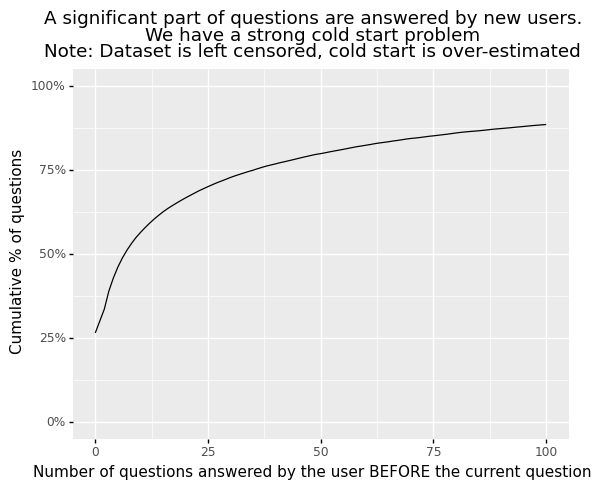

<ggplot: (8785828477477)>

In [4]:
# For exploratory data analysis I like to use pandas-profiling but
# it would be over-kill here
LOGGER.info(f"Number of unique question_id: {questions['question_id'].nunique()}")
LOGGER.info(f"Number of unique user_id: {questions['user_id'].nunique()}")

plot = analysis.plot_previous_answer_count(questions)
plot.save(path.path_artifact("plot_previous_answer_count.png"))
plot

In [5]:
print('Two main families of models are implemented.')
print(model.NearestNeighborsModel.__doc__)
print(model.TwoStepModel.__doc__)

Two main families of models are implemented.
NearestNeighborsModel is a model based on a-kNN candidate retrieval. Then
    candidates are ranked by distance
TwoStepModel model is based on NearestNeighborsModel for candidate retrieval
    then on another more classical model to "rerank" these candidates. This second
    model can take as input more features (eg user recency, ...)


In [6]:
models_to_benchmark = [
    model.TFIDF(N_CANDIDATES=20),
    model.TFIDF_SVD(N_CANDIDATES=20),
    model.TFIDF_SVD_LGBM(),
    model.SentenceTransformer(20),
    model.SentenceTransformer_LGBM(),
]
for my_model in models_to_benchmark:
    print(my_model.model_name)
    print(my_model.__doc__, '\n')

2021-09-02 10:13:06 INFO: Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
2021-09-02 10:13:06 INFO: Use pytorch device: cpu
2021-09-02 10:13:06 INFO: Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
2021-09-02 10:13:06 INFO: Use pytorch device: cpu


TFIDF
NearestNeighborsModel model based on model_embeddings.TFIDF_Embeddings() 

TFIDF_SVD
NearestNeighborsModel model based on model_embeddings.TFIDF_SVD_Embeddings() 

TFIDF_SVD_LGBM
A TwoStepModel model based on TFIDF_SVD and model_second.LGBM_custom 

SentenceTransformer
NearestNeighborsModel model based on
    model_embeddings.SentenceTransformer_Embeddings() 

SentenceTransformer_LGBM
A TwoStepModel model based on SentenceTransformer and model_second.LGBM_custom 



In [7]:
for my_model in models_to_benchmark:
    LOGGER.info(f"Benchmark model:{my_model.model_name}")
    valid = prep.get_valid_and_predict(questions, my_model)
    metrics.log_metrics(my_model.model_name, valid)
    if hasattr(my_model, "second_model"):
        if hasattr(my_model.second_model, "model_lgb"):
            importance = ml_utils.get_importance_lgb(
                my_model.second_model.model_lgb
            )
            plot = ml_utils.plot_importance_lgb(importance)
            plot.save(path.path_artifact("plot_importance_lgb.png"))

experiments = metrics.get_previous_experiments(len(models_to_benchmark))
experiments.to_csv(path.path_artifact("benchmark_experiments.csv"), index=False)

2021-09-02 10:13:06 INFO: Benchmark model:TFIDF
2021-09-02 10:13:06 INFO: Create valid set for date 2020-11-30
2021-09-02 10:13:08 INFO: Create valid set for date 2020-12-01
2021-09-02 10:13:09 INFO: Create valid set for date 2020-12-02
2021-09-02 10:13:11 INFO: Create valid set for date 2020-12-03
2021-09-02 10:13:12 INFO: Create valid set for date 2020-12-04
2021-09-02 10:13:13 INFO: Create valid set for date 2020-12-05
2021-09-02 10:13:15 INFO: Create valid set for date 2020-12-06
2021-09-02 10:13:17 INFO: Metrics computed:
2021-09-02 10:13:17 INFO: precision_at_1: 0.0
2021-09-02 10:13:17 INFO: precision_at_5: 0.0
2021-09-02 10:13:17 INFO: precision_at_20: 0.0
2021-09-02 10:13:17 INFO: recall_at_1: 0.0
2021-09-02 10:13:17 INFO: recall_at_5: 0.0
2021-09-02 10:13:17 INFO: recall_at_20: 0.0
2021-09-02 10:13:17 INFO: mean_reciprocal_rank: 0.0
2021-09-02 10:13:17 INFO: Benchmark model:TFIDF_SVD
2021-09-02 10:13:17 INFO: Create valid set for date 2020-11-30
2021-09-02 10:13:20 INFO: Creat

Training until validation scores don't improve for 300 rounds
[50]	training's ndcg@5: 1	valid_1's ndcg@5: 0.987678
[100]	training's ndcg@5: 1	valid_1's ndcg@5: 0.987816
[150]	training's ndcg@5: 1	valid_1's ndcg@5: 0.987816
[200]	training's ndcg@5: 1	valid_1's ndcg@5: 0.987816
[250]	training's ndcg@5: 1	valid_1's ndcg@5: 0.987816
[300]	training's ndcg@5: 1	valid_1's ndcg@5: 0.987816
Early stopping, best iteration is:
[1]	training's ndcg@5: 0.997154	valid_1's ndcg@5: 0.990501


2021-09-02 10:13:53 INFO: Create valid set for date 2020-12-01
2021-09-02 10:13:55 INFO: Create valid set for date 2020-12-02
2021-09-02 10:13:57 INFO: Create valid set for date 2020-12-03
2021-09-02 10:13:59 INFO: Create valid set for date 2020-12-04
2021-09-02 10:14:02 INFO: Create valid set for date 2020-12-05
2021-09-02 10:14:03 INFO: Create valid set for date 2020-12-06
2021-09-02 10:14:05 INFO: Metrics computed:
2021-09-02 10:14:05 INFO: precision_at_1: 0.0001049
2021-09-02 10:14:05 INFO: precision_at_5: 0.0001799
2021-09-02 10:14:05 INFO: precision_at_20: 0.0001799
2021-09-02 10:14:05 INFO: recall_at_1: 0.01049
2021-09-02 10:14:05 INFO: recall_at_5: 0.01799
2021-09-02 10:14:05 INFO: recall_at_20: 0.01799
2021-09-02 10:14:05 INFO: mean_reciprocal_rank: 0.01374
2021-09-02 10:14:06 INFO: Benchmark model:SentenceTransformer
2021-09-02 10:14:06 INFO: Create valid set for date 2020-11-30
Batches: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]
2021-09-02 10:16:16 INFO: Create valid set 

Training until validation scores don't improve for 300 rounds
[50]	training's ndcg@5: 1	valid_1's ndcg@5: 0.910569
[100]	training's ndcg@5: 1	valid_1's ndcg@5: 0.909294
[150]	training's ndcg@5: 1	valid_1's ndcg@5: 0.909672
[200]	training's ndcg@5: 1	valid_1's ndcg@5: 0.910067
[250]	training's ndcg@5: 1	valid_1's ndcg@5: 0.909929
[300]	training's ndcg@5: 1	valid_1's ndcg@5: 0.910963
[350]	training's ndcg@5: 1	valid_1's ndcg@5: 0.910652
Early stopping, best iteration is:
[72]	training's ndcg@5: 1	valid_1's ndcg@5: 0.912645


Batches: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
2021-09-02 10:47:07 INFO: Create valid set for date 2020-12-01
Batches: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]
2021-09-02 10:49:34 INFO: Create valid set for date 2020-12-02
Batches: 100%|██████████| 5/5 [00:01<00:00,  4.72it/s]
2021-09-02 10:51:46 INFO: Create valid set for date 2020-12-03
Batches: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]
2021-09-02 10:54:12 INFO: Create valid set for date 2020-12-04
Batches: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
2021-09-02 10:56:24 INFO: Create valid set for date 2020-12-05
Batches: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]
2021-09-02 10:58:30 INFO: Create valid set for date 2020-12-06
Batches: 100%|██████████| 1/1 [00:00<00:00, 39.99it/s]
2021-09-02 11:00:38 INFO: Metrics computed:
2021-09-02 11:00:38 INFO: precision_at_1: 0.0007646
2021-09-02 11:00:38 INFO: precision_at_5: 0.001499
2021-09-02 11:00:38 INFO: precision_at_20: 0.002129
2021-09-02 11:00:38 INFO: recall_at_1:

In [8]:
# We can observe what is the best model
experiments

model_name  mean_reciprocal_rank  recall_at_1  recall_at_5  recall_at_20  precision_at_1  precision_at_5  precision_at_20
0  SentenceTransformer_LGBM                0.1108       0.0765       0.1499        0.2129          0.0008          0.0015           0.0021
0       SentenceTransformer                0.0312       0.0135       0.0495        0.0975          0.0007          0.0025           0.0049
0            TFIDF_SVD_LGBM                0.0137       0.0105       0.0180        0.0180          0.0001          0.0002           0.0002
0                 TFIDF_SVD                0.0006       0.0000       0.0000        0.0060          0.0000          0.0000           0.0003
0                     TFIDF                0.0000       0.0000       0.0000        0.0000          0.0000          0.0000           0.0000

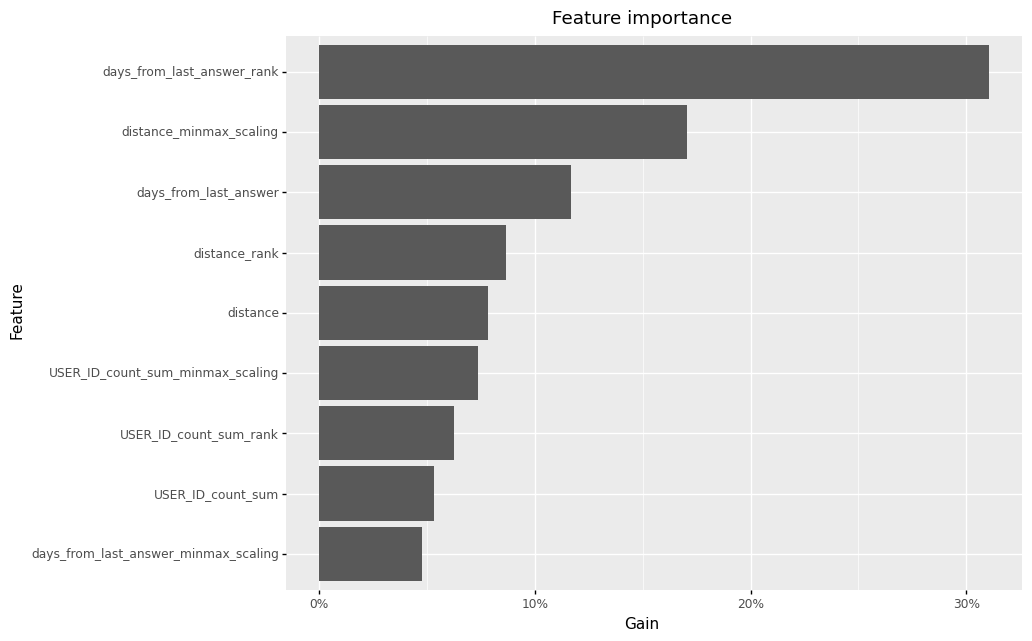

<ggplot: (8785823143797)>

In [9]:
# We can also be curious at knowing are the keys features for 2 stage model
plot

2021-09-02 11:00:40 INFO: Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
2021-09-02 11:00:40 INFO: Use pytorch device: cpu
2021-09-02 11:00:40 INFO: Create valid set for date 2020-11-30
Batches: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]
2021-09-02 11:02:48 INFO: Create valid set for date 2020-12-01
Batches: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]
2021-09-02 11:04:55 INFO: Create valid set for date 2020-12-02
Batches: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]
2021-09-02 11:06:52 INFO: Create valid set for date 2020-12-03
Batches: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]
2021-09-02 11:09:04 INFO: Create valid set for date 2020-12-04
Batches: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]
2021-09-02 11:11:09 INFO: Create valid set for date 2020-12-05
Batches: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s]
2021-09-02 11:13:22 INFO: Create valid set for date 2020-12-06
Batches: 100%|██████████| 1/1 [00:00<00:00, 95.41it/s]


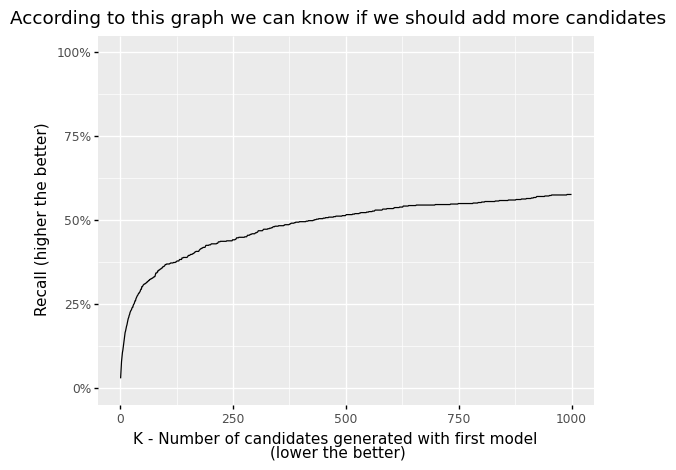

<ggplot: (8785740371613)>

In [10]:
# Debug we want to know what is the bottleneck and answer the question:
# Is it worth adding more candidates?
my_model = model.SentenceTransformer(N_CANDIDATES=1_000)
valid = prep.get_valid_and_predict(questions, my_model)
plot = analysis.plot_recall_by_candidates(valid)
plot.save(path.path_artifact("plot_recall_by_candidates.png"))
plot

# run_pipeline

Ok we found our best model, run our pipeline and predict questions_test 

In [11]:
%load_ext memory_profiler

In [12]:
def run_pipeline_train_predict() -> None:
    """Run the pipeline which includes:
    * training the desired algorithm
    * predict the test questions
    """
    LOGGER.info(f"CURRENT_ENVIRONMENT: {constants.CURRENT_ENVIRONMENT}")

    LOGGER.info("Read data & preprocessing")
    questions = prep.read_questions()
    questions_test = prep.read_questions_test()

    LOGGER.info("Train model")
    my_model = model.SentenceTransformer_LGBM()
    my_model.train(questions)

    LOGGER.info("Predict questions_test")
    # Here assume this the day following the last one from historical questions
    date_to_predict = questions["date_answer_date"].max() + pd.Timedelta(days=1)

    questions_test["date_answer_date"] = date_to_predict
    submission = my_model.predict(questions_test, questions)
    submission = prep.format_submission(submission)
    submission.to_csv(path.path_artifact("submission.csv"), index=False)

In [13]:
%time %memit run_pipeline_train_predict()

2021-09-02 11:15:48 INFO: CURRENT_ENVIRONMENT: preprod
2021-09-02 11:15:48 INFO: Read data & preprocessing


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2021-09-02 11:15:49 INFO: Train model
2021-09-02 11:15:49 INFO: Load pretrained SentenceTransformer: paraphrase-MiniLM-L6-v2
2021-09-02 11:15:49 INFO: Use pytorch device: cpu
Batches: 100%|██████████| 1/1 [00:00<00:00, 66.61it/s]
2021-09-02 11:32:24 INFO: Train LGB on 69 positive examples
2021-09-02 11:32:24 INFO: Validate LGB on 90 positive examples


Training until validation scores don't improve for 300 rounds
[50]	training's ndcg@5: 1	valid_1's ndcg@5: 0.862835
[100]	training's ndcg@5: 1	valid_1's ndcg@5: 0.857894
[150]	training's ndcg@5: 1	valid_1's ndcg@5: 0.857962
[200]	training's ndcg@5: 1	valid_1's ndcg@5: 0.858016
[250]	training's ndcg@5: 1	valid_1's ndcg@5: 0.859094
[300]	training's ndcg@5: 1	valid_1's ndcg@5: 0.858066
Early stopping, best iteration is:
[3]	training's ndcg@5: 0.997603	valid_1's ndcg@5: 0.870297


Batches: 100%|██████████| 372/372 [02:11<00:00,  2.83it/s]
2021-09-02 11:34:38 INFO: Predict questions_test
Batches: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s]


peak memory: 1907.88 MiB, increment: 563.86 MiB
CPU times: user 35min 48s, sys: 24.8 s, total: 36min 13s
Wall time: 18min 56s


# Final words

We can still improve the pipeline (eg number of candidates, better second stage models, and probably other things) but I think that the codebase give a wide perspective of what can be done and that it is now easy to iterate on this if we want. 

Current NearestNeighbours models rely on the title of the questions previously answered. To improve embeddings I would try to also take into account the content of the question, the answer of the user. And create my own embeddings. It is still not 100% clear for me how I would do it but I would definitely hav a look at winning solution on a recent Kaggle Competition about product matching where embeddings based on text/image needed to be created and the use of a specific loss (ArcFace) to create "supervised" embededdings by opposition of our current embeddings which are not supervised/specific to our problem.
https://www.kaggle.com/c/shopee-product-matching/overview

Another key improvement is described in the function read_questions(). We keep questions and the accepted answer only. We are therefore throwing away some users answers (even if they were not accepted). It could help the cold start problem by having more data for each users.  

Looking forward discussing it with you! 